In [6]:
# importing the libraries
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for datamanagement
import pandas as pd

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
import torch.nn as nn
from torch.autograd import Variable

# for downloading our dataset
from sklearn.datasets import fetch_openml

# for data pre-processing
from sklearn.preprocessing import MinMaxScaler

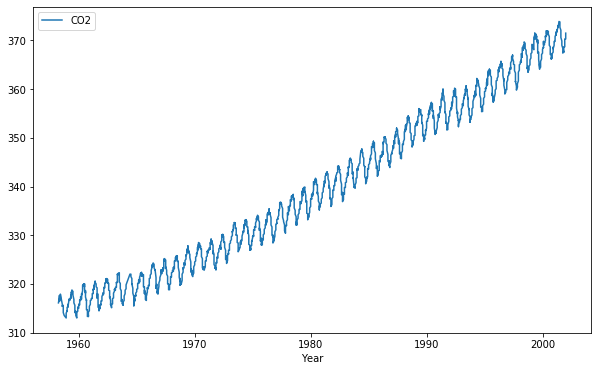

In [7]:
# Download the Mauna Loa CO2 Dataset
ml_data = fetch_openml(data_id=41187)

# ml_df = pd.DataFrame(ml_data['data'], columns=ml_data['feature_names'])
ml_df = pd.DataFrame({
    'Year': ml_data['data'][:, 0] + ml_data['data'][:, 1] /12,
    'CO2': ml_data['target']
})
ml_df.plot(x='Year', y='CO2',figsize=(10, 6))


In [37]:
training_set = ml_df.iloc[:,1:2]


# Our raw data is a single 1-d vector
# we construct input data that is of dimensions
# input -> (n_samples, sequence_length, 1)
# output -> (n_samples, 1)

# How long do we want to consider?
seq_length = 10


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [39]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
                
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        # define initial states of the LSTM (optional, defaults to zeros)
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        # reshape hidden layer output for fully connected network
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [40]:
num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.64827
Epoch: 500, loss: 0.00027
Epoch: 1000, loss: 0.00017
Epoch: 1500, loss: 0.00012
Epoch: 2000, loss: 0.00009
Epoch: 2500, loss: 0.00008
Epoch: 3000, loss: 0.00007
Epoch: 3500, loss: 0.00006
Epoch: 4000, loss: 0.00006
Epoch: 4500, loss: 0.00006


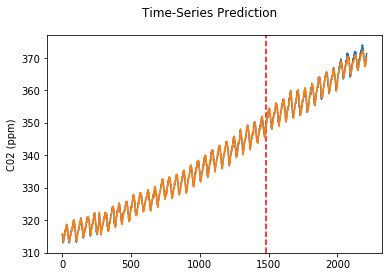

Mean Squared Error on Predictions: 294.2004089355469


In [41]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.ylabel('C02 (ppm)')
plt.show()

mse = np.sum((data_predict[train_size:] - dataY_plot[train_size:])**2)
print(f"Mean Squared Error on Predictions: {mse}")